# Capstone project: The Battle of Neighbourhoods

## Introduction/Business Problem

I am a very enthusiastic traveller and that's why I am planning to focus on comparison of neighbourhoods in Toronto, particularly which part of the city can offer me and other tourists the best opportunities for sightseeing, culture and fun. I did some research, as I usually do before any journey and I was suprised with this fact: on Jan. 1, 1998, Toronto’s amalgamation took effect, merging the six previous municipalities that made up Metro Toronto – Etobicoke, Scarborough, York, East York, North York, and the City of Toronto, into a new singular City of Toronto. It seems Toronto has, like any other big city, a very interesting history.

The aim of this project is to focus on Toronto's neighbourhoods in order to find the best part of the city for tourist activities (with respect to Art & Entertainment). The analysis is built on the information available on Foursquare webpage, so I want to highligh it has some limitations in content.


## Data Description
The data for this project is extracted from the following sources:

Toronto's Neighbourhoods data 
<br>
Description: general information about the Toronto's neighbourhoods, such as postal code, name. This data set is used to explore various neighborhoods of Toronto. 
<br>
Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Geospace data 
<br>
Description: geographical coordinates. This source provides data for Toronto's borough boundaries. 
<br>
Link: http://cocl.us/Geospatial_data

Foursquare API 
<br>
Description: service where the user can search and discover information about different types of entertainment, such as coffee shops, restaurants, including the rating and tips. It is needed for detailed neighbourhood exploration, based on different criteria. 
<br>
Link: https://api.foursquare.com

## Aproach
- gather the Toronto's neighbourhoods data
- clean data
- use Foursquare API to get information about venues for each neighbourhood
- focus on Art and Entertainment category - purposes of this project
- find ratings, tips via Fourswuare API
- visulize the neighbourhoods's segments via Folium library

## Methodology section

The project should recommend the best neighbourhoods for tourist entertainment in Toronto (Canada). Such neighbourhood should have historic sites and also additional art and entertainment places. 

The firts stage of the project gathers data from different sources: Toronto's neighbourhoods, geographical coordinates, art and enteratinment places from Foursquare API. After cleaning up of the dataset, the analysis focuses on deeper understanding what each neighbourhood can offer. The frequency of occuerence of various categories existng in each neighborhoud is also counted. 
In the last step, the neighbourhoods are clustered based on the type of category. This cluster part should help the tourist with the starting decision which neighborhoud deserves time. 

## 1. Toronto neighbourhoods

Let's firstly get the basic information about the Toronto's neighbourhoods, such as postal code, borough, neighbourhood name. This information is available on Wikipedia and the Python library called BeautifulSoupe is used for pulling data out of HTML files. 
As a next step, data needs to be cleaned up
- to ignore cells with a borough that is Not assigned; 
- more than one neighborhood can exist in one postal code area. Such two rows will be combined into one row with the neighborhoods separated with a comma. 
- if a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

Finally, .csv file prepared for next work. 

In [2]:
#libraries import
import pandas as pd  # library for data analysis
import numpy as np # library to handle data in a vectorized manner
import requests # library to handle requests
import matplotlib.pyplot as plt # provides a MATLAB-like plotting framework.
from bs4 import BeautifulSoup # library to pull data from HTML and XMLS files

In [3]:
# link for BeautifulSoup: https://www.youtube.com/watch?v=ng2o98k983k
link = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html = requests.get(link).text
Toronto_data = BeautifulSoup(html, 'lxml')

# dataframe creation
column_names = ['Postalcode','Borough','Neighborhood']
Toronto = pd.DataFrame(columns = column_names)

In [4]:
# data extraction: postalcode, borough, neighborhood

content = Toronto_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    Toronto = Toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

# clean 
Toronto = Toronto[Toronto.Borough!='Not assigned']
Toronto = Toronto[Toronto.Borough!= 0]
Toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,Toronto.shape[0]):
    if Toronto.iloc[i][2] == 'Not assigned':
        Toronto.iloc[i][2] = Toronto.iloc[i][1]
        i = i+1
                                 
df = Toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

Postalcode      Borough                            Neighborhood
0        M1B  Scarborough                          Rouge, Malvern
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union
2        M1E  Scarborough       Guildwood, Morningside, West Hill
3        M1G  Scarborough                                  Woburn
4        M1H  Scarborough                               Cedarbrae

In [5]:
# data cleaning
df= df.dropna()
NA = 'Not assigned'
df = df[(df.Postalcode != NA ) & (df.Borough != NA) & (df.Neighborhood != NA)]
df.head()

Postalcode      Borough                            Neighborhood
0        M1B  Scarborough                          Rouge, Malvern
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union
2        M1E  Scarborough       Guildwood, Morningside, West Hill
3        M1G  Scarborough                                  Woburn
4        M1H  Scarborough                               Cedarbrae

In [6]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
group_1 = df.groupby(['Postalcode', 'Borough'])
df_2 = group_1.apply(neighborhood_list).reset_index(name='Neighborhood')

print(df_2.shape)

(103, 3)


In [7]:
# export dataset to .csv file since it will be used in next step
df_2.to_csv('Toronto_part1.csv')

There are 103 neighbourhoods in Toronto city.

## 2. Neighbourhood's location data 

In this part of the project, I am looking for geographical coordinates for each Toronto's neighbourhood. Essentially naming convention is needed (for the columns name: Postal code, Neihbourhood) before the merge of two tables. Again .csv file created as a preparation for next step.

In [8]:
# import .csv file from the previous step (for learning purposes)
df_neigh=pd.read_csv('Toronto_part1.csv', index_col=[0])
df_neigh.head()

Postalcode      Borough                            Neighborhood
0        M1B  Scarborough                          Rouge, Malvern
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union
2        M1E  Scarborough       Guildwood, Morningside, West Hill
3        M1G  Scarborough                                  Woburn
4        M1H  Scarborough                               Cedarbrae

In [9]:
# read .csv file with geographical coordinates from link, load into dataframe
url = 'http://cocl.us/Geospatial_data'
df_coord = pd.read_csv(url)

In [10]:
# same naming convention for the column with postal code and neighbourhood
df_coord.rename(columns={'Postal Code': 'PostalCode', 'Neighborhood': 'Neighbourhood'}, inplace=True)
df_neigh.rename(columns={'Postalcode': 'PostalCode', 'Neighborhood': 'Neighbourhood'}, inplace=True)

# merge datasets based on the Postalcode
df_neigh_coord = pd.merge(df_neigh, df_coord, on='PostalCode')
df_neigh_coord.head()

PostalCode      Borough                           Neighbourhood   Latitude  \
0        M1B  Scarborough                          Rouge, Malvern  43.806686   
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [11]:
# export dataset to .csv file since it will be used in next step
df_neigh_coord.to_csv('Toronto_part2.csv')

I have complete dataset: details about the Toronto's neighbourhoods including the geographical coordinates. 

## 3. Toronto's neighbourhoods in details

Let's focus more on visualization to see how many neighbourhoods are in each borough. Some additional libraries have to be imported, the Folium for leaflet map is used. The bar plot shows the number of neighbourhoods in each borough. 

In [12]:
# import of libraries, which will be used in this part of project

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [13]:
# import .csv file from the previous step
df_neigh_coord=pd.read_csv('Toronto_part2.csv', index_col=[0])

# Use geopy library to get the latitude and longitude values of Toronto.
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Let''use Folium map to visualize the neighbourhoods in Toronto. The goal is to get a view regarding the coordinates of particualr Borough.

In [101]:
# a map of Toronto with neighborhoods superimposed on top.
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df_neigh_coord['Latitude'], df_neigh_coord['Longitude'], df_neigh_coord['Borough'], df_neigh_coord['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

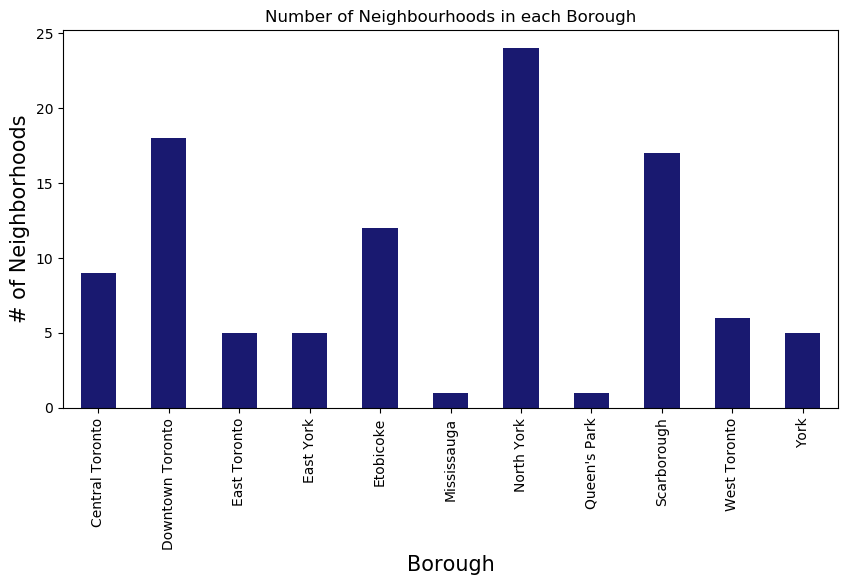

In [15]:
# graph used for representation of the number of neighbourhoods in each Borough in Toronto
plt.figure(figsize=(10,5), dpi = 100)
plt.title('Number of Neighbourhoods in each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('# of Neighborhoods', fontsize=15)
df_neigh_coord.groupby('Borough')['Neighbourhood'].count().plot(kind='bar', color = 'midnightblue')

plt.show()

It is North York borough with the highest number of neighborhouds. Next in the row are Downtown Toronto and Scarborough. 

## 4. Foursquare APIs used for explaratory analysis
Now, let's utilize the Foursquare API to explore the neighborhoods, in terms of art and entertainment. This should provide the reader a good overview of the areas which are more residential and those ones which represent historical site. The decision correspons with the goal of this project. 

In [104]:
# define Foursquare credentials and version
CLIENT_ID = 'XXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXX' # your Foursquare Secret
VERSION = '20190915' # Foursquare API version
LIMIT = 100 # limit the number of venues returned by Foursquare API
#radius = 4000 # to define radius

We need the list of all art and entertainment categories in the neighbourhoods. The category ID for Art and Entertainment has been extracted from Foursquare webpage (link: https://developer.foursquare.com/docs/resources/categories).

In [17]:
ArtEntertainment_category = '4d4b7104d754a06370d81259' # Foursquare API category id for all types of art & entertainment

def getNearbyArt(names, latitudes, longitudes, radius=4000):
    
    venues_list=[]
    art_count = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            lat, 
            lng,
            VERSION,
            ArtEntertainment_category,
            radius)
            
        # make the GET request
        results = requests.get(url).json()
        results = results['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name,
                v['id'], 
                v['name'],
                v['location']['formattedAddress'],
                v['location']['lat'],
                v['location']['lng'],
                v['location']['distance'],
                v['categories'][0]['name']) for v in results])

    nearby_art = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_art.columns = ['Neighbourhood','Id', 
                  'Name', 
                  'Address', 
                  'Latitude', 
                  'Longitude',
                  'Distance','Category']
    
    return(nearby_art)

In [105]:
# read from local file in case the task was done
try:
    Toronto_art = pd.read_csv('Toronto_art.csv', index_col=[0])
except:
    Toronto_art = getNearbyArt(names=df_neigh_coord['Neighbourhood'],
                                   latitudes=df_neigh_coord['Latitude'],
                                   longitudes=df_neigh_coord['Longitude']
                                  )
    # export dataset to .csv file
    Toronto_art.to_csv('Toronto_art.csv')

In [106]:
Toronto_art.shape

(2920, 8)

In [20]:
Toronto_art.head()

Neighbourhood                        Id                Name  \
0  Rouge, Malvern  516c46cbe4b0e67c18a7c76d  Wood Bison Paddock   
1  Rouge, Malvern  4c97ac2782b56dcb0fceebaa   Americas Pavillon   
2  Rouge, Malvern  4bf9849d5efe2d7f455f6c34  simba safari lodge   
3  Rouge, Malvern  4ad4c05ef964a52093f620e3         Toronto Zoo   
4  Rouge, Malvern  4bf590095e800f47b1b8e5d4  Polar Bear Exhibit   

                                             Address   Latitude  Longitude  \
0                                           [Canada]  43.811732 -79.200708   
1                                           [Canada]  43.822083 -79.185665   
2    [316a old finch avenue, Scarborough ON, Canada]  43.817305 -79.185904   
3  [361 Old Finch Av (at Meadowvale & Toronto Zoo...  43.820582 -79.181551   
4                       [Toronto ON M1X 1L3, Canada]  43.823372 -79.185145   

   Distance     Category  
0       758  Zoo Exhibit  
1      1850  Zoo Exhibit  
2      1363  Zoo Exhibit  
3      1857          Zoo  
4      1999          Zoo

We should check if there are any duplicities in the list. I assume there are some as the radius is set up to 4000 to cover the whole borough. A function is built which deletes duplicates based on the remoteness of the place.  

In [21]:
def find_duplicates(df):
    id_to_neighbourhood = {}
    
    # create dictionary for unique ids with values for all neighborhood, distance tuples
    for venue_id,neighbourhood,distance in zip(df['Id'],df['Neighbourhood'],df['Distance']):
        if venue_id not in id_to_neighbourhood:
            id_to_neighbourhood[venue_id] = [(neighbourhood,distance)]
        else:
            id_to_neighbourhood[venue_id].append((neighbourhood,distance))
    
    final_df = {}
    
    # select the neighborhood with minimum distance value
    for key,value in id_to_neighbourhood.items():
        data = min(value,key = lambda x:x[1])
        final_df[key] = data
    final_df = pd.DataFrame.from_dict(final_df,orient = 'index',columns = ['Neighbourhood','Distance'])
    final_df.reset_index(inplace=True)
    final_df.rename(columns={"index":"Id"},inplace=True)
    return final_df

In [22]:
Toronto_art_final = find_duplicates(Toronto_art)
Toronto_art_final.shape

(557, 3)

In [106]:
Toronto_art_final.head()

Id   Neighbourhood  Distance
0  5155c164e4b02256def736f2  Rouge, Malvern      1130
1  4bf9849d5efe2d7f455f6c34  Rouge, Malvern      1363
2  4c97ac2782b56dcb0fceebaa  Rouge, Malvern      1850
3  4ad4c05ef964a52093f620e3  Rouge, Malvern      1857
4  4bf596d25efe2d7fbd936534  Rouge, Malvern      1978

It seems a lof of duplicates has been removed. We will work with 557 rows, instead of 2920. 

When duplicites removed, we need the table with full data. 

In [23]:
# merge of two dataframes to see all relevant information
cols = ['Neighbourhood','Id','Name','Address','Latitude','Longitude','Distance_x','Category']
Toronto_art = pd.merge(Toronto_art_final, Toronto_art,on=["Id",'Neighbourhood'],how="inner")[cols].rename(columns=lambda x: x.split('_')[0])
Toronto_art.head()

Neighbourhood                        Id                Name  \
0  Rouge, Malvern  516c46cbe4b0e67c18a7c76d  Wood Bison Paddock   
1  Rouge, Malvern  4c97ac2782b56dcb0fceebaa   Americas Pavillon   
2  Rouge, Malvern  4bf9849d5efe2d7f455f6c34  simba safari lodge   
3  Rouge, Malvern  4ad4c05ef964a52093f620e3         Toronto Zoo   
4  Rouge, Malvern  4bf590095e800f47b1b8e5d4  Polar Bear Exhibit   

                                             Address   Latitude  Longitude  \
0                                           [Canada]  43.811732 -79.200708   
1                                           [Canada]  43.822083 -79.185665   
2    [316a old finch avenue, Scarborough ON, Canada]  43.817305 -79.185904   
3  [361 Old Finch Av (at Meadowvale & Toronto Zoo...  43.820582 -79.181551   
4                       [Toronto ON M1X 1L3, Canada]  43.823372 -79.185145   

   Distance     Category  
0       758  Zoo Exhibit  
1      1850  Zoo Exhibit  
2      1363  Zoo Exhibit  
3      1857          Zoo  
4      1999          Zoo

In [24]:
Toronto_art.shape

(557, 8)

It will be helpful to see art and entertainment grouped and visualize them along with neighbourhood markers to get a better idea of their distribution.

In [103]:
from folium import plugins

Toronto_art_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around Toronto

art_enter = plugins.MarkerCluster().add_to(Toronto_art_map)

# add blue circle markers to represent the neighborhoods
for lat, lng, label in zip(df_neigh_coord['Latitude'], df_neigh_coord['Longitude'], df_neigh_coord['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6,
        parse_html=False).add_to(Toronto_art_map)

# add the art&entertainment markers
for lat, lng, label,neighborhood in zip(Toronto_art['Latitude'], Toronto_art['Longitude'], Toronto_art['Name'],Toronto_art['Neighbourhood']):
    label = '{} ({})'.format(label,neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='red',icon='home')).add_to(art_enter)

# display map
Toronto_art_map

In [28]:
# let's count unique art&entertainment categories
print('There are {} uniques categories.'.format(len(Toronto_art['Category'].unique())))

There are 90 uniques categories.


Foursquare category "Art and Entertainment" is represented by 90 unique sub-categories in all Toronto's neighbourhood. Let's look closer on the count of art and entertainment in each neighbourhood. 

In [55]:
entertainment_counts = Toronto_art.groupby('Neighbourhood')['Id'].count().to_frame().reset_index().rename(columns={'Id':'Entertainment_Count'})
entertainment_counts.head()

Neighbourhood  Entertainment_Count
0                           Adelaide, King, Richmond                    3
1                                          Agincourt                    8
2  Agincourt North, L'Amoreaux East, Milliken, St...                   14
3  Albion Gardens, Beaumond Heights, Humbergate, ...                   10
4                             Alderwood, Long Branch                   12

We'll merge the counts with Toronto neighbourhoods dataframe and fill zero where there are no entertainment places.

In [57]:
# Merge the entertainment counts with neighborhoods data
Toronto_neighbourhoods = pd.merge(df_neigh_coord,entertainment_counts,on="Neighbourhood",how="left").fillna(0)
Toronto_neighbourhoods.head()

PostalCode      Borough                           Neighbourhood   Latitude  \
0        M1B  Scarborough                          Rouge, Malvern  43.806686   
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  Entertainment_Count  
0 -79.194353                 30.0  
1 -79.160497                  0.0  
2 -79.188711                 15.0  
3 -79.216917                  5.0  
4 -79.239476                  6.0

In [61]:
Toronto_neighbourhoods.sort_values("Entertainment_Count",ascending=False)

PostalCode           Borough  \
0          M1B       Scarborough   
86         M7R       Mississauga   
2          M1E       Scarborough   
14         M1V       Scarborough   
83         M6R      West Toronto   
102        M9W         Etobicoke   
87         M7Y      East Toronto   
33         M3N        North York   
42         M4L      East Toronto   
82         M6P      West Toronto   
89         M8W         Etobicoke   
76         M6H      West Toronto   
88         M8V         Etobicoke   
37         M4E      East Toronto   
95         M9C         Etobicoke   
17         M2H        North York   
97         M9M        North York   
30         M3K        North York   
27         M3C        North York   
96         M9L        North York   
22         M2N        North York   
8          M1M       Scarborough   
101        M9V         Etobicoke   
71         M6A        North York   
9          M1N       Scarborough   
29         M3J        North York   
12         M1S       Scarborough   
64         M5P   Central Toronto   
6          M1K       Scarborough   
84         M6S      West Toronto   
92         M8Z         Etobicoke   
10         M1P       Scarborough   
41         M4K      East Toronto   
59         M5J  Downtown Toronto   
21         M2M        North York   
81         M6N              York   
4          M1H       Scarborough   
78         M6K      West Toronto   
63         M5N   Central Toronto   
18         M2J        North York   
39         M4H         East York   
3          M1G       Scarborough   
100        M9R         Etobicoke   
80         M6M              York   
98         M9N              York   
90         M8X         Etobicoke   
62         M5M        North York   
43         M4M      East Toronto   
99         M9P         Etobicoke   
11         M1R       Scarborough   
5          M1J       Scarborough   
72         M6B        North York   
74         M6E              York   
45         M4P   Central Toronto   
93         M9A         Etobicoke   
36         M4C         East York   
24         M2R        North York   
47         M4S   Central Toronto   
79         M6L        North York   
65         M5R   Central Toronto   
94         M9B         Etobicoke   
91         M8Y         Etobicoke   
54         M5B  Downtown Toronto   
23         M2P        North York   
58         M5H  Downtown Toronto   
13         M1T       Scarborough   
44         M4N   Central Toronto   
53         M5A  Downtown Toronto   
60         M5K  Downtown Toronto   
7          M1L       Scarborough   
25         M3A        North York   
26         M3B        North York   
20         M2L        North York   
50         M4W  Downtown Toronto   
15         M1W       Scarborough   
38         M4G         East York   
35         M4B         East York   
67         M5T  Downtown Toronto   
34         M4A        North York   
49         M4V   Central Toronto   
40         M4J         East York   
32         M3M        North York   
52         M4Y  Downtown Toronto   
28         M3H        North York   
55         M5C  Downtown Toronto   
73         M6C              York   
69         M5W  Downtown Toronto   
68         M5V  Downtown Toronto   
66         M5S  Downtown Toronto   
19         M2K        North York   
16         M1X       Scarborough   
61         M5L  Downtown Toronto   
48         M4T   Central Toronto   
31         M3L        North York   
85         M7A      Queen's Park   
46         M4R   Central Toronto   
1          M1C       Scarborough   
77         M6J      West Toronto   
75         M6G  Downtown Toronto   
56         M5E  Downtown Toronto   
57         M5G  Downtown Toronto   
70         M5X  Downtown Toronto   
51         M4X  Downtown Toronto   

                                         Neighbourhood   Latitude  Longitude  \
0                                       Rouge, Malvern  43.806686 -79.194353   
86               Canada Post Gateway Processing Centre  43.636966 -79.615819   
2                  

It seems like there are 14 neighbourhoods in Toronto which do not have even one place for entertainment. These ones cannot be recommended to the tourists at all.

## 5. Deeper analysis of each neighbourhood
Now, then we have an idea about the overall picture of art and entertainment, the deeper analysis is needed for each neigbourhood. One hot encoding is used for next analysis (when "1" means that a category is there, "0" in case the category is not there). On the basis of one hot encoding, the mean of the frequency of occurence of each category will be calculated. As a next step, top 10 Art and Entertainment categories for each neighbourhood is extracted.

In [29]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_art[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto_art['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

Neighbourhood  Amphitheater  Aquarium  Arcade  Art Gallery  Art Museum  \
0  Rouge, Malvern             0         0       0            0           0   
1  Rouge, Malvern             0         0       0            0           0   
2  Rouge, Malvern             0         0       0            0           0   
3  Rouge, Malvern             0         0       0            0           0   
4  Rouge, Malvern             0         0       0            0           0   

   Arts & Entertainment  Athletics & Sports  BBQ Joint  Bar  Baseball Stadium  \
0                     0                   0          0    0                 0   
1                     0                   0          0    0                 0   
2                     0                   0          0    0                 0   
3                     0                   0          0    0                 0   
4                     0                   0          0    0                 0   

   Basketball Stadium  Beer Bar  Bookstore  Botanical Garden  Bowling Alley  \
0                   0         0          0                 0              0   
1                   0         0          0                 0              0   
2                   0         0          0                 0              0   
3                   0         0          0                 0              0   
4                   0         0          0                 0              0   

   Casino  Castle  Church  Coffee Shop  College Arts Building  \
0       0       0       0            0                      0   
1       0       0       0            0                      0   
2       0       0       0            0                      0   
3       0       0       0            0                      0   
4       0       0       0            0                      0   

   College Auditorium  College Cafeteria  College Theater  Comedy Club  \
0                   0                  0                0            0   
1                   0                  0                0            0   
2                   0                  0                0            0   
3                   0                  0                0            0   
4                   0                  0                0            0   

   Concert Hall  Country Dance Club  Cricket Ground  Dance Studio  \
0             0                   0               0             0   
1             0                   0               0             0   
2             0                   0               0             0   
3             0                   0               0             0   
4             0                   0               0             0   

   Electronics Store  Event Space  Exhibit  Football Stadium  \
0                  0            0        0                 0   
1                  0            0        0                 0   
2                  0            0        0                 0   
3                  0            0        0                 0   
4                  0            0        0                 0   

   General Entertainment  Go Kart Track  Golf Course  Government Building  \
0                      0              0            0                    0   
1                      0              0            0                    0   
2                      0              0            0                    0   
3                      0              0            0                    0   
4                      0              0            0                    0   

   Gym  Gym / Fitness Center  Historic Site  History Museum  Hockey Arena  \
0    0                     0              0               0             0   
1    0                     0              0               0             0   
2    0                     0              0               0             0   
3    0                     0              0               0             0   
4    0                     0              0               0             0   

   Hotel  I

In [30]:
# let's group rows by neighbourhood
Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').mean().reset_index()
Toronto_grouped.head()

Neighbourhood  Amphitheater  Aquarium  \
0                           Adelaide, King, Richmond           0.0       0.0   
1                                          Agincourt           0.0       0.0   
2  Agincourt North, L'Amoreaux East, Milliken, St...           0.0       0.0   
3  Albion Gardens, Beaumond Heights, Humbergate, ...           0.0       0.0   
4                             Alderwood, Long Branch           0.0       0.0   

     Arcade  Art Gallery  Art Museum  Arts & Entertainment  \
0  0.000000     0.000000         0.0                 0.000   
1  0.125000     0.125000         0.0                 0.125   
2  0.071429     0.071429         0.0                 0.000   
3  0.000000     0.100000         0.0                 0.100   
4  0.166667     0.000000         0.0                 0.000   

   Athletics & Sports  BBQ Joint  Bar  Baseball Stadium  Basketball Stadium  \
0            0.000000        0.0  0.0          0.000000                 0.0   
1            0.000000        0.0  0.0          0.000000                 0.0   
2            0.071429        0.0  0.0          0.071429                 0.0   
3            0.000000        0.1  0.0          0.000000                 0.0   
4            0.000000        0.0  0.0          0.000000                 0.0   

   Beer Bar  Bookstore  Botanical Garden  Bowling Alley  Casino  Castle  \
0       0.0        0.0               0.0            0.0     0.0     0.0   
1       0.0        0.0               0.0            0.0     0.0     0.0   
2       0.0        0.0               0.0            0.0     0.0     0.0   
3       0.0        0.0               0.0            0.0     0.0     0.0   
4       0.0        0.0               0.0            0.0     0.0     0.0   

   Church  Coffee Shop  College Arts Building  College Auditorium  \
0     0.0          0.0                    0.0                 0.0   
1     0.0          0.0                    0.0                 0.0   
2     0.0          0.0                    0.0                 0.0   
3     0.0          0.0                    0.0                 0.0   
4     0.0          0.0                    0.0                 0.0   

   College Cafeteria  College Theater  Comedy Club  Concert Hall  \
0                0.0              0.0     0.000000           0.0   
1                0.0              0.0     0.000000           0.0   
2                0.0              0.0     0.071429           0.0   
3                0.0              0.0     0.000000           0.0   
4                0.0              0.0     0.000000           0.0   

   Country Dance Club  Cricket Ground  Dance Studio  Electronics Store  \
0                 0.0        0.000000      0.000000                0.0   
1                 0.0        0.000000      0.125000                0.0   
2                 0.0        0.071429      0.214286                0.0   
3                 0.0        0.000000      0.000000                0.0   
4                 0.0        0.000000      0.166667                0.0   

   Event Space  Exhibit  Football Stadium  General Entertainment  \
0          0.0      0.0               0.0               0.000000   
1          0.0      0.0               0.0               0.000000   
2          0.0      0.0               0.0               0.071429   
3          0.0      0.0               0.0               0.000000   
4          0.0      0.0               0.0               0.250000   

   Go Kart Track  Golf Course  Government Building       Gym  \
0            0.0          0.0                  0.0  0.000000   
1            0.0          0.0                  0.0  0.000000   
2            0.0          0.0                  0.0  0.000000   
3            0.0          0.0                  0.0  0.000000   
4            0.0          0.0                  0.0  0.083333   

   Gym / Fitness Center  Historic Site  History Museum  Hockey Arena  Hotel  \
0                   0.0          0.000             0.0           0.0    0.0   
1                   0.0          0.125

Let's create the dataframe and display the top 10 categories for each neighbourhood.

In [31]:
# let's write a function to sort the categories in descending order.
def return_most_common_categories(row, num_top_categories):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_categories]

In [32]:
# let's create the new dataframe and display the top 10 categories for each neighborhood.
num_top_categories = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_categories):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
neighborhoods_categories_sorted['Neighbourhood'] = Toronto_grouped['Neighbourhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_categories(Toronto_grouped.iloc[ind, :], num_top_categories)

neighborhoods_categories_sorted.head()

Neighbourhood 1st Most Common Category  \
0                           Adelaide, King, Richmond            Movie Theater   
1                                          Agincourt                Pool Hall   
2  Agincourt North, L'Amoreaux East, Milliken, St...             Dance Studio   
3  Albion Gardens, Beaumond Heights, Humbergate, ...            Movie Theater   
4                             Alderwood, Long Branch    General Entertainment   

  2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
0                  Theater              Zoo Exhibit    General Entertainment   
1                   Arcade              Art Gallery     Arts & Entertainment   
2              Music Venue                Pool Hall                   Arcade   
3      Indie Movie Theater               Water Park              Art Gallery   
4                Pool Hall                   Arcade             Dance Studio   

  5th Most Common Category 6th Most Common Category 7th Most Common Category  \
0             Concert Hall       Country Dance Club           Cricket Ground   
1             Dance Studio            Historic Site              Music Venue   
2              Art Gallery           Cricket Ground       Athletics & Sports   
3     Arts & Entertainment                BBQ Joint            Go Kart Track   
4                Laser Tag    Performing Arts Venue                      Gym   

  8th Most Common Category 9th Most Common Category 10th Most Common Category  
0             Dance Studio        Electronics Store               Event Space  
1    General Entertainment       Country Dance Club            Cricket Ground  
2         Baseball Stadium              Comedy Club             Movie Theater  
3       Country Dance Club           Cricket Ground              Dance Studio  
4                  Exhibit             Concert Hall        Country Dance Club

Let's visualize what are the most common types of art and entertainment in Toronto neighbourhoods.

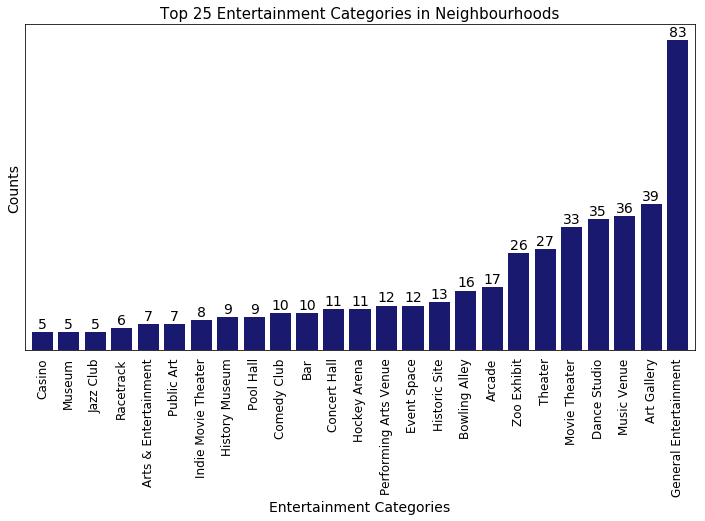

In [33]:
categories_counts = Toronto_onehot.groupby('Neighbourhood').sum().reset_index()
categories_counts = categories_counts.sum().rename('Count')

# Get the top 25 categories
Toronto_top10 = categories_counts.to_frame().drop('Neighbourhood').sort_values(by='Count')[-25:]


labels = Toronto_top10['Count']

# plot the bar chart
ax = Toronto_top10.plot(kind='bar', rot=90, width = 0.8,figsize=(12,6), color = 'midnightblue')

# Put text labels on bars
rects = ax.patches
for rect, count in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.3, count,
            ha='center', va='bottom', fontsize=14)

ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True) # remove borders
ax.xaxis.set_tick_params(labelsize=12)
ax.set_title('Top 25 Entertainment Categories in Neighbourhoods',fontsize=15) # set title and add font size as 15
ax.set_xlabel('Entertainment Categories',fontsize=14)
ax.set_ylabel('Counts',fontsize=14)
ax.get_legend().remove()

plt.show()

Based on the above analysis, it seems there are only 13 historic sites in Toronto and 9 history museums. Closer analysis also shows that Zoo Exhibit category is reperesented only by one place, with a few exibities. The best category is general entertainment. 

## 6. Cluster neighbourhoods
Machine learning technique - clustering - is applied to segment the neighbourhoods into similar objects cluster. This final step will help with the clarification which neighbourhoods should be on Tourist agenda. 

In [46]:
#run K-means to cluster into 5 clusters

# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 2, 1, 4, 4, 4, 1, 1], dtype=int32)

In [42]:
# add clustering labels
#neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
Toronto_merged = df_neigh_coord

# merge two datasets to add latitude/longitude for each neighbourhood
Toronto_merged = Toronto_merged.join(neighborhoods_categories_sorted.set_index('Neighbourhood'), on='Neighbourhood')

Toronto_merged.head()

PostalCode      Borough                           Neighbourhood   Latitude  \
0        M1B  Scarborough                          Rouge, Malvern  43.806686   
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  Cluster Labels 1st Most Common Category  \
0 -79.194353             1.0              Zoo Exhibit   
1 -79.160497             NaN                      NaN   
2 -79.188711             1.0    General Entertainment   
3 -79.216917             1.0    General Entertainment   
4 -79.239476             4.0    General Entertainment   

  2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
0                      Zoo             Tram Station            Movie Theater   
1                      NaN                      NaN                      NaN   
2              Art Gallery              Music Venue            Indie Theater   
3            Indie Theater              Art Gallery               Theme Park   
4       Athletics & Sports                  Theater            Movie Theater   

  5th Most Common Category 6th Most Common Category 7th Most Common Category  \
0                 Aquarium            Go Kart Track       Country Dance Club   
1                      NaN                      NaN                      NaN   
2                   Arcade             Dance Studio               Theme Park   
3                Bookstore              Zoo Exhibit       Country Dance Club   
4              Zoo Exhibit             Concert Hall       Country Dance Club   

  8th Most Common Category 9th Most Common Category 10th Most Common Category  
0           Cricket Ground             Dance Studio         Electronics Store  
1                      NaN                      NaN                       NaN  
2                      Bar              Zoo Exhibit            Cricket Ground  
3           Cricket Ground             Dance Studio         Electronics Store  
4           Cricket Ground             Dance Studio         Electronics Store

### Cluster visualizations

In [107]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

### Cluster examination
Looking for the category which defines each particular cluster. 

In [44]:
# cluster 1 
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Category  \
20  North York             0.0               Playground   
25  North York             0.0              Art Gallery   
73        York             0.0              Event Space   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
20              Event Space              Zoo Exhibit          College Theater   
25              Event Space              Zoo Exhibit            Go Kart Track   
73              Zoo Exhibit          College Theater             Concert Hall   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
20             Concert Hall       Country Dance Club           Cricket Ground   
25             Concert Hall       Country Dance Club           Cricket Ground   
73       Country Dance Club           Cricket Ground             Dance Studio   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
20             Dance Studio        Electronics Store                   Exhibit  
25             Dance Studio        Electronics Store                   Exhibit  
73        Electronics Store                  Exhibit          Football Stadium

This cluster does not offer very huge range of activities or interesting places for sightseeing. 

In [51]:
#cluster 2 
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Category  \
0         Scarborough             1.0              Zoo Exhibit   
2         Scarborough             1.0    General Entertainment   
3         Scarborough             1.0    General Entertainment   
5         Scarborough             1.0            Bowling Alley   
8         Scarborough             1.0              Music Venue   
11        Scarborough             1.0                Pool Hall   
12        Scarborough             1.0                Pool Hall   
13        Scarborough             1.0      Indie Movie Theater   
14        Scarborough             1.0             Dance Studio   
17         North York             1.0    General Entertainment   
18         North York             1.0                  Theater   
21         North York             1.0             Dance Studio   
22         North York             1.0                   Arcade   
23         North York             1.0    General Entertainment   
24         North York             1.0                Multiplex   
27         North York             1.0           Science Museum   
30         North York             1.0              Music Venue   
33         North York             1.0             Hockey Arena   
34         North York             1.0             Hockey Arena   
35          East York             1.0              Art Gallery   
36          East York             1.0              Coffee Shop   
37       East Toronto             1.0    General Entertainment   
39          East York             1.0              Comedy Club   
40          East York             1.0               Sports Bar   
41       East Toronto             1.0          College Theater   
42       East Toronto             1.0    Performing Arts Venue   
43       East Toronto             1.0                  Theater   
55   Downtown Toronto             1.0                  Theater   
59   Downtown Toronto             1.0      Monument / Landmark   
60   Downtown Toronto             1.0             Concert Hall   
63    Central Toronto             1.0       Italian Restaurant   
64    Central Toronto             1.0              Music Venue   
65    Central Toronto             1.0    General Entertainment   
67   Downtown Toronto             1.0                    Hotel   
69   Downtown Toronto             1.0             Concert Hall   
71         North York             1.0            Movie Theater   
74               York             1.0                   Museum   
76       West Toronto             1.0      Indie Movie Theater   
78       West Toronto             1.0              Music Venue   
79         North York             1.0     Arts & Entertainment   
80               York             1.0              Art Gallery   
81               York             1.0                   Arcade   
82       West Toronto             1.0              Music Venue   
83       West Toronto             1.0                      Bar   
84       West Toronto             1.0                Jazz Club   
86        Mississauga             1.0              Music Venue   
87       East Toronto             1.0             Dance Studio   
88          Etobicoke             1.0    General Entertainment   
89          Etobicoke             1.0    General Entertainment   
90          Etobicoke             1.0      Indie Movie Theater   
91          Etobicoke             1.0      Indie Movie Theater   
92          Etobicoke             1.0             Concert Hall   
93          Etobicoke             1.0                Pool Hall   
94          Etobicoke             1.0            Historic Site   
95          Etobicoke             1.0              Art Gallery   
96         North York             1.0             Dance Studio   
97         North York             1.0    General Entertainment   
99          Etobicoke             1.0    General Entertainment   
100         Etobicoke             1.0    General Entertainment   
102         Etobicoke             1.0    General Enter

The second cluster seems to be more tourist friendly, with some venues, galleries and studios.

In [48]:
#cluster 3
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Category  \
45    Central Toronto             2.0            Movie Theater   
47    Central Toronto             2.0            Movie Theater   
49    Central Toronto             2.0            Movie Theater   
54   Downtown Toronto             2.0            Movie Theater   
58   Downtown Toronto             2.0            Movie Theater   
68   Downtown Toronto             2.0            Movie Theater   
101         Etobicoke             2.0            Movie Theater   

    2nd Most Common Category 3rd Most Common Category  \
45                 Jazz Club              Art Gallery   
47               Video Store              Art Gallery   
49               Zoo Exhibit    General Entertainment   
54                     Plaza    General Entertainment   
58                   Theater              Zoo Exhibit   
68               Zoo Exhibit    General Entertainment   
101      Indie Movie Theater               Water Park   

    4th Most Common Category 5th Most Common Category  \
45               Zoo Exhibit            Go Kart Track   
47               Zoo Exhibit    General Entertainment   
49              Concert Hall       Country Dance Club   
54               Comedy Club             Concert Hall   
58     General Entertainment             Concert Hall   
68              Concert Hall       Country Dance Club   
101              Art Gallery     Arts & Entertainment   

    6th Most Common Category 7th Most Common Category  \
45        Country Dance Club           Cricket Ground   
47              Concert Hall       Country Dance Club   
49            Cricket Ground             Dance Studio   
54        Country Dance Club           Cricket Ground   
58        Country Dance Club           Cricket Ground   
68            Cricket Ground             Dance Studio   
101                BBQ Joint            Go Kart Track   

    8th Most Common Category 9th Most Common Category  \
45              Dance Studio        Electronics Store   
47            Cricket Ground             Dance Studio   
49         Electronics Store              Event Space   
54              Dance Studio        Electronics Store   
58              Dance Studio        Electronics Store   
68         Electronics Store              Event Space   
101       Country Dance Club           Cricket Ground   

    10th Most Common Category  
45                Event Space  
47          Electronics Store  
49                    Exhibit  
54                Event Space  
58                Event Space  
68                    Exhibit  
101              Dance Studio

Third segment is oriented a lot on art and free time activities. 

In [53]:
#cluster 4
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Category  \
38         East York             3.0                   Arcade   
50  Downtown Toronto             3.0             Music School   
52  Downtown Toronto             3.0            Historic Site   
53  Downtown Toronto             3.0            Historic Site   
66  Downtown Toronto             3.0                   Museum   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
38            Historic Site              Zoo Exhibit    General Entertainment   
50            Historic Site    General Entertainment             Concert Hall   
52              Zoo Exhibit    General Entertainment             Concert Hall   
53                   Museum              Zoo Exhibit    General Entertainment   
66              Zoo Exhibit    General Entertainment             Concert Hall   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
38             Concert Hall       Country Dance Club           Cricket Ground   
50       Country Dance Club           Cricket Ground             Dance Studio   
52       Country Dance Club           Cricket Ground             Dance Studio   
53             Concert Hall       Country Dance Club           Cricket Ground   
66       Country Dance Club           Cricket Ground             Dance Studio   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
38             Dance Studio        Electronics Store               Event Space  
50        Electronics Store              Event Space                   Exhibit  
52        Electronics Store              Event Space                   Exhibit  
53             Dance Studio        Electronics Store               Event Space  
66        Electronics Store              Event Space                   Exhibit

This part of the city is defined by historic sites. 

In [50]:
# cluster 5 
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Category  \
4       Scarborough             4.0    General Entertainment   
6       Scarborough             4.0    General Entertainment   
7       Scarborough             4.0    General Entertainment   
9       Scarborough             4.0    General Entertainment   
10      Scarborough             4.0    General Entertainment   
15      Scarborough             4.0    General Entertainment   
26       North York             4.0    General Entertainment   
28       North York             4.0    General Entertainment   
29       North York             4.0    General Entertainment   
32       North York             4.0    General Entertainment   
44  Central Toronto             4.0             Dance Studio   
62       North York             4.0             Dance Studio   
72       North York             4.0    General Entertainment   
98             York             4.0    General Entertainment   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
4        Athletics & Sports                  Theater            Movie Theater   
6                Sports Bar                Laser Tag     Arts & Entertainment   
7             Movie Theater              Zoo Exhibit             Concert Hall   
9                    Arcade              Art Gallery             Dance Studio   
10               Public Art           History Museum                  Theater   
15              Zoo Exhibit          College Theater             Concert Hall   
26         Botanical Garden              Zoo Exhibit             Concert Hall   
28              Zoo Exhibit          College Theater             Concert Hall   
29              Art Gallery           History Museum             Dance Studio   
32              Zoo Exhibit          College Theater             Concert Hall   
44    General Entertainment              Zoo Exhibit          College Theater   
62    General Entertainment              Comedy Club          College Theater   
72           Soccer Stadium         Football Stadium              Comedy Club   
98            Historic Site    Performing Arts Venue                   Office   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
4               Zoo Exhibit             Concert Hall       Country Dance Club   
6                 Rock Club             Concert Hall       Country Dance Club   
7        Country Dance Club           Cricket Ground             Dance Studio   
9                   Exhibit              Music Venue              Zoo Exhibit   
10            Bowling Alley         Football Stadium             Concert Hall   
15       Country Dance Club           Cricket Ground             Dance Studio   
26       Country Dance Club           Cricket Ground             Dance Studio   
28       Country Dance Club           Cricket Ground             Dance Studio   
29              Zoo Exhibit             Concert Hall       Country Dance Club   
32       Country Dance Club           Cricket Ground             Dance Studio   
44             Concert Hall       Country Dance Club           Cricket Ground   
62             Concert Hall       Country Dance Club           Cricket Ground   
72             Concert Hall       Country Dance Club           Cricket Ground   
98         Football Stadium             Concert Hall       Country Dance Club   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
4            Cricket Ground             Dance Studio         Electronics Store  
6            Cricket Ground             Dance Studio         Electronics Store  
7         Electronics Store              Event Space                   Exhibit  
9        Country Dance Club           Cricket Ground         Electronics Store  
10       Country Dance Club           Cricket Ground              Dance Studio  
15        Electronics Store              Event Space                   Exhibit  
26        Electronics Store              Event Space

The last cluster is represented mainly by general entertainment category. 

## Results
The clustering technique was used as the main source for Tourits orientation over the Toronto's neighbourhoods. Two  boroughs - Etobicoke and Downton Toronto - should be visited in case tourists are interested in historic site places. The neighbourhoods are similar to each other in all art and entertainment categories, like exhibits, general entertainment or studios. The result of the analysis corresponds with the expectations - big cities offer a lot of entertainment. 

## Discussion
Downton Toronto is recommended for visit in case the tourists prefer historical sites and also some other art and entertainment places. It is difficult to find any dissimallarity in regards to the chosen Art and Entertainment category as the analysis focused on big city, each neighbourhood has a lot of places for relax and fun. The analysis is built on the Foursquare API basis, which means the list of art and entertaiment category should not be seen as the final one.

## Conclusion
The above analysis confirmed that Toronto, as any other big city in the world, can offer a lot of interesting places to the tourists. And still it is true that every city is unique in its own way. 